In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-tg86mxvp
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-tg86mxvp
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184144 sha256=b5f55032f5c3d72d6bcf82802db2a78eb6c154f7850b65526c657053b960d70f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qqweeeil/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [2]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp()) / "tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

2.14.0


In [3]:
gz = tf.keras.utils.get_file(
    "HIGGS.csv.gz",
    "http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz"
)

FEATURES = 28

2816407858/2816407858 [==============================] - 430s 0us/step


In [4]:
ds = tf.data.experimental.CsvDataset(
    gz,
    [float(),]*(FEATURES+1),
    compression_type="GZIP"
)

In [5]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


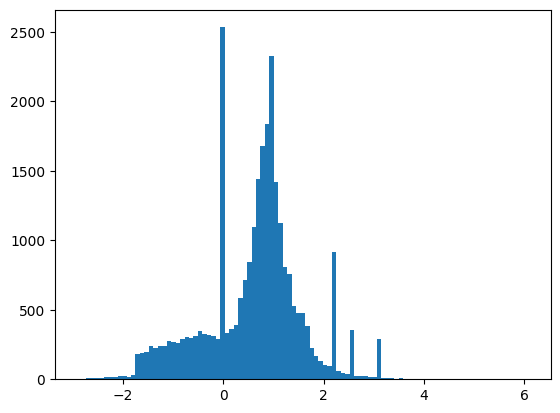

In [6]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [7]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN / BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [8]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

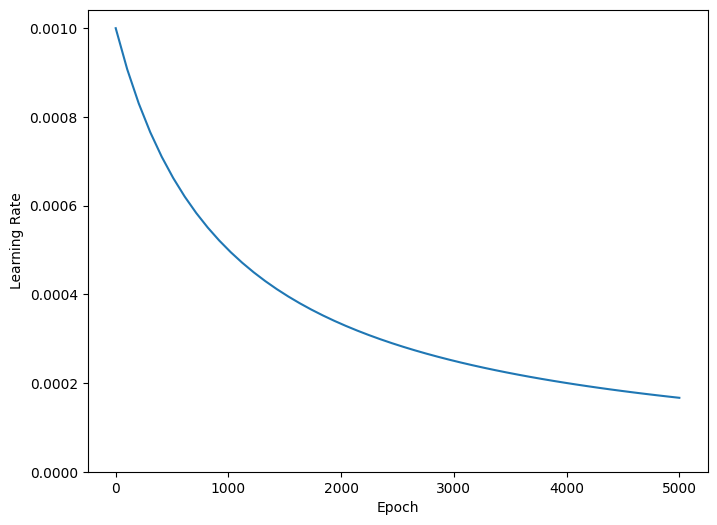

In [10]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")

In [13]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_binary_crossentropy", patience=200
        ),
        tf.keras.callbacks.TensorBoard(logdir / name)
    ]

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(
                          from_logits=True, name="binary_crossentropy"
                      ),
                      "accuracy"
                  ])

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0
    )

    return history

In [14]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories = {}

size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4888,  binary_crossentropy:0.7707,  loss:0.7707,  val_accuracy:0.4820,  val_binary_crossentropy:0.7465,  val_loss:0.7465,  
....................................................................................................
Epoch: 100, accuracy:0.5980,  binary_crossentropy:0.6265,  loss:0.6265,  val_accuracy:0.5940,  val_binary_crossentropy:0.6242,  val_loss:0.6242,  
..........................

(0.5, 0.7)

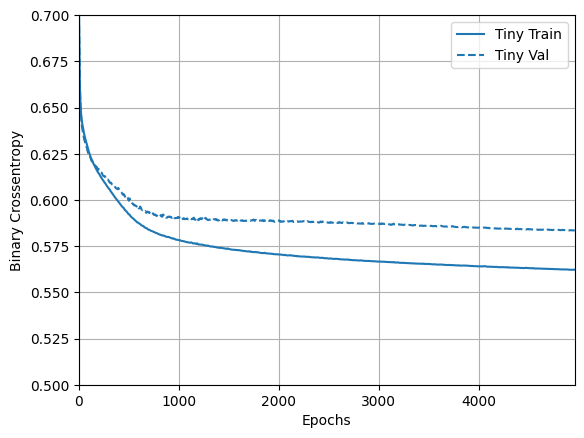

In [16]:
plotter = tfdocs.plots.HistoryPlotter(
    metric="binary_crossentropy",
    smoothing_std=10
)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [19]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
    layers.Dense(16, activation="elu"),
    layers.Dense(1)
])

size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                464       
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4768,  binary_crossentropy:0.7280,  loss:0.7280,  val_accuracy:0.4660,  val_binary_crossentropy:0.7042,  val_loss:0.7042,  
....................................................................................................
Epoch: 100, accuracy:0.6082,  binary_cros

In [20]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
    layers.Dense(64, activation="elu"),
    layers.Dense(64, activation="elu"),
    layers.Dense(1)
])

size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                1856      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4844,  binary_crossentropy:0.6994,  loss:0.6994,  val_accuracy:0.4830,  val_binary_crossentropy:0.6813,  val_loss:0.6813,  
....

In [21]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
    layers.Dense(512, activation="elu"),
    layers.Dense(512, activation="elu"),
    layers.Dense(512, activation="elu"),
    layers.Dense(1)
])

size_histories["Large"] = compile_and_fit(large_model, "sizes/Large")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 512)               14848     
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

Text(0.5, 0, 'Epochs [Log Scale]')

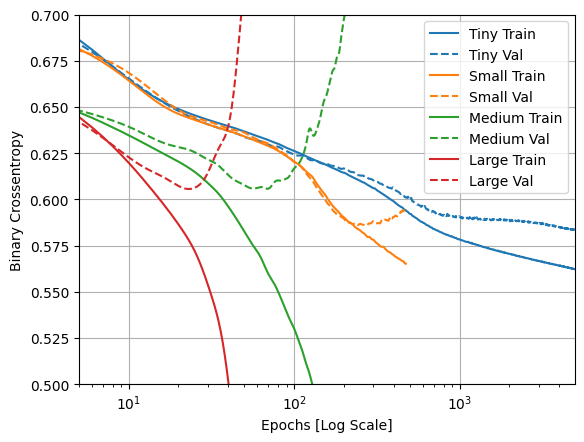

In [22]:
plotter.plot(size_histories)
a = plt.xscale("log")
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [27]:
shutil.rmtree(logdir / "regularizers/Tiny", ignore_errors=True)
shutil.copytree(logdir / "sizes/Tiny", logdir / "regularizers/Tiny")

regularizer_histories = {}
regularizer_histories["Tiny"] = size_histories["Tiny"]

In [31]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation="elu",
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation="elu",
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation="elu",
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation="elu",
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories["l2"] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               14848     
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dense_24 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

(0.5, 0.7)

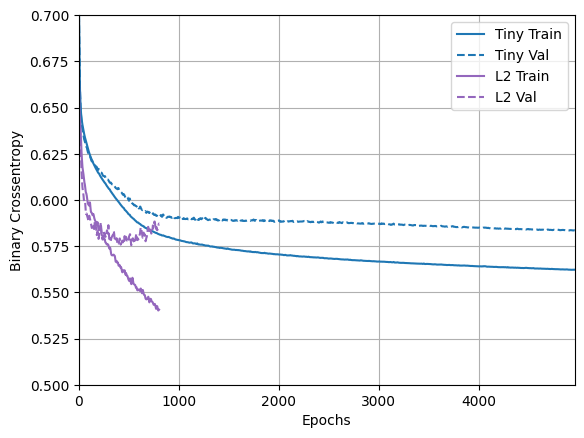

In [32]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 512)              

(0.5, 0.7)

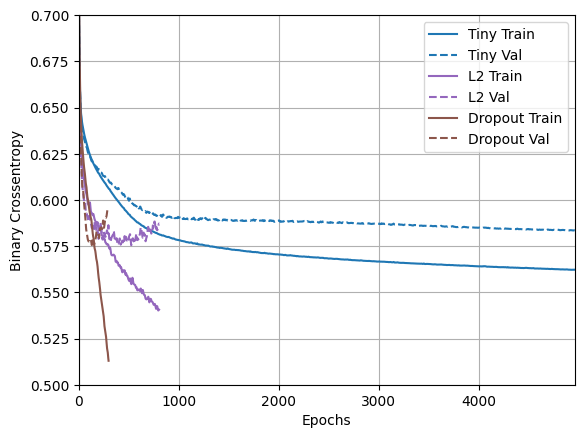

In [34]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories["dropout"] = compile_and_fit(dropout_model, "regularizer/dropout")

plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 512)               14848     
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_41 (Dense)            (None, 512)               262656    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 512)               262656    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 512)              

(0.5, 0.7)

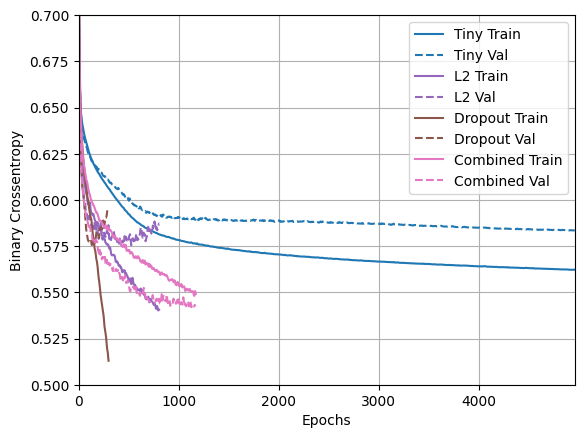

In [38]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation="elu", input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories["combined"] = compile_and_fit(
    combined_model, "regularizer/combined"
)

plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [1]:
# MIT License
#
# Copyright (c) 2017 François Chollet
# Copyright (c) 2023 KURAMOCHI Kenta
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.